In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.base.datetools import dates_from_str

## Constructing an Arma Model

In [56]:
df = pd.read_csv("US_Full_Quarterly.csv",index_col="DATE")
df["Log GDP"] = np.log(df["GDP"])
df["Diff Log GDP"] = df["Log GDP"] - df["Log GDP"].shift(1)
df["Log Inv"] = np.log(df["Inv"])
df["Diff Log Inv"] = df["Log Inv"] - df["Log Inv"].shift(1)
df

,GDP,Inv,Exp,Imp,Gov,Cons,NXP,Fertility,Unemployment,Life_exp,...,recession_1973,recession_1980,recession_1990,recession_2001,recession_2008,recession_2020,Log GDP,Diff Log GDP,Log Inv,Diff Log Inv
DATE,,,,,,,,,,,,,,,,,,,,,
1947-01-01,243.164,35.854,18.394,7.519,40.902,156.111288,10.875,NaN,NaN,NaN,...,0,0,0,0,0,0,5.493736,NaN,3.579455,NaN
1947-04-01,245.968,34.505,19.497,8.203,40.346,160.125168,11.294,NaN,NaN,NaN,...,0,0,0,0,0,0,5.505201,0.011465,3.541104,-0.038351
1947-07-01,249.585,34.911,19.433,7.663,42.007,163.478175,11.770,NaN,NaN,NaN,...,0,0,0,0,0,0,5.519800,0.014598,3.552802,0.011698
1947-10-01,259.745,43.250,17.636,8.347,38.149,167.795270,9.289,NaN,NaN,NaN,...,0,0,0,0,0,0,5.559700,0.039901,3.766997,0.214195
1948-01-01,265.742,47.202,16.917,9.624,38.915,170.340622,7.293,NaN,3.4,NaN,...,0,0,0,0,0,0,5.582526,0.022826,3.854436,0.087439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,26408.405,4796.162,3013.800,3891.004,6175.709,17915.100000,-877.204,NaN,3.6,NaN,...,1,1,1,1,1,1,10.181438,0.015792,8.475571,0.015029
2023-01-01,26813.601,4725.828,3064.804,3890.491,6324.782,18229.600000,-825.687,NaN,3.4,NaN,...,1,1,1,1,1,1,10.196665,0.015227,8.460798,-0.014773
2023-04-01,27063.012,4780.290,2961.759,3767.851,6346.294,18363.800000,-806.092,NaN,3.4,NaN,...,1,1,1,1,1,1,10.205923,0.009259,8.472256,0.011458


In [61]:
# Combine variables into a single DataFrame
# I opted to start at 1990 because that's when the data starts to become yearly. 
# We should really fix the dataset to get yearly data for the first 30 years though
variables = ['Diff Log GDP',"Diff Log Inv","Dependency"]
df_var = df[variables].loc['1960-01-01':'2020-02-01']
df_var.index = pd.period_range(start='1960-01-01', end='2020-02-01', freq='Q-DEC')

# Fit VARMAX model
model = VARMAX(df_var, order=(4, 4)) # TODO: I chose the order (p=2,q=2) arbitrarily. We should probably do some AIC or something to find the best choice
results = model.fit(disp=False)

/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/acherpeski/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

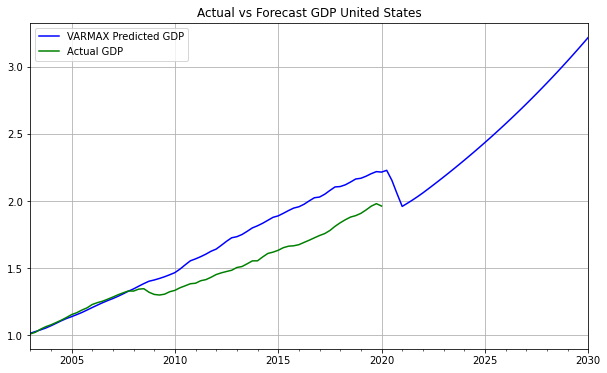

In [73]:
# Forecast GDP
forecast_steps = 5  # Number of steps ahead to forecast
forecast = results.forecast(steps=forecast_steps)

# These two lines let us plot confidence intervals I think
#forecast_obj = results.get_forecast('2020')
#allConfidenceIntervals = forecast_obj.conf_int(alpha=0.05)

# Plot GDP along with the smoothed version (and forecasted through 2030)
pred = results.predict('1960', '2030') # If we wanted to show only the future prediction, we would change the start date to 2017
np.exp(np.cumsum(pred['Diff Log GDP'].loc['2003-01-01':])).plot(figsize=(10,6), label="VARMAX Predicted GDP", color='b', markersize=4)
plt.plot(np.exp(np.cumsum(df_var['Diff Log GDP'].loc['2003-01-01':])), label="Actual GDP", color='g', markersize=4)
plt.title('Actual vs Forecast GDP United States')
plt.legend()
plt.grid(True)
plt.show()